In [4]:
import numpy as np

In [63]:
fimp = [(6, np.float32(0.17037272)),
 (5, np.float32(0.1590208)),
 (7, np.float32(0.14158085)),
 (8, np.float32(0.10678079)),
 (4, np.float32(0.10320448)),
 (1, np.float32(0.09372504)),
 (3, np.float32(0.09318691)),
 (2, np.float32(0.08965151)),
 (0, np.float32(0.021792948)),
 (9, np.float32(0.020683898))]

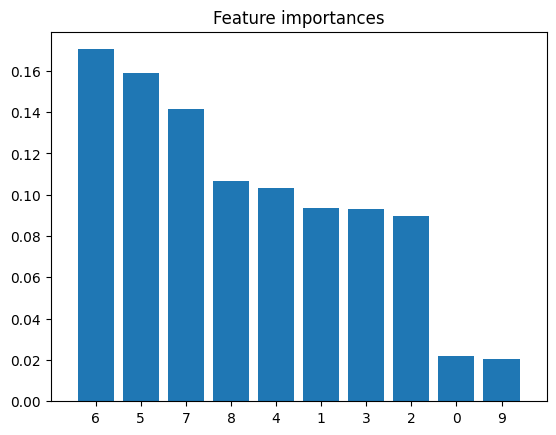

In [64]:
# plot the feature importances
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(fimp)), [f[1] for f in fimp], align="center")
plt.xticks(range(len(fimp)), [f[0] for f in fimp])
plt.xlim([-1, len(fimp)])
plt.show()


In [65]:
fimp = dict(fimp)

In [66]:
fimp

{6: np.float32(0.17037272),
 5: np.float32(0.1590208),
 7: np.float32(0.14158085),
 8: np.float32(0.10678079),
 4: np.float32(0.10320448),
 1: np.float32(0.09372504),
 3: np.float32(0.09318691),
 2: np.float32(0.08965151),
 0: np.float32(0.021792948),
 9: np.float32(0.020683898)}

In [67]:
def assign_splits(avg_splits, feature_importance):
    '''
    Assigns splits to each feature based on the average number of splits per feature and feature importance.
    '''
    features = len(feature_importance)
    total_importance = sum(feature_importance.values())
    total_splits = avg_splits * features
    splits_per_feature = {feature: round(total_splits * feature_importance[feature]/total_importance) for feature in feature_importance}
    return splits_per_feature

In [68]:
assign_splits(3, fimp)

{6: 5, 5: 5, 7: 4, 8: 3, 4: 3, 1: 3, 3: 3, 2: 3, 0: 1, 9: 1}

In [52]:
def sample_n_features(n, feature_importance):
    '''
    Samples n features from the feature importance distribution.
    '''
    # Convert feature importance values to a numpy array and cast to float64
    probabilities = np.array(list(feature_importance.values()), dtype=np.float64)

    # Normalize probabilities to ensure they sum exactly to 1
    probabilities /= probabilities.sum()

    return np.random.choice(list(feature_importance.keys()), n, p=list(probabilities), replace=False)

In [69]:
sample_n_features(30, fimp)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [71]:
a = [1, 2, 3, 4, 5]
b = [2, 3]

# a-b
list(set(a) - set(b))

[1, 4, 5]

In [72]:
import pandas as pd
import numpy as np

# Sample dataset
data_df = pd.DataFrame({
    0: [0.2, 0.4, 0.7],
    1: [0.4, 0.6, 0.8]
})
data_np = data_df.to_numpy()

# Define feature splits
feature_splits = {
    0: [0.3, 0.6],
    1: [0.5]
}

# Original function using pandas
def get_region_indices_pandas(self, df):
    print('Optimized: Getting regions (Pandas)')
    df = df.reset_index(drop=True)
    
    feature_splits = self.feature_splits
    features = list(feature_splits.keys())
    feature_masks = {}
    for feature in features:
        splits = feature_splits[feature]
        masks = []
        for i, split in enumerate(splits):
            lower_mask = (df[feature] > splits[i - 1]) if i > 0 else np.ones(len(df), dtype=bool)
            upper_mask = (df[feature] <= split)
            masks.append(lower_mask & upper_mask)
        masks.append(df[feature] > splits[-1])
        feature_masks[feature] = masks

    regions = {}
    def combine_masks(feature_idx, current_mask, region_key):
        if feature_idx == len(features):
            regions[tuple(region_key)] = df[current_mask].index.tolist()
            return
        
        feature = features[feature_idx]
        for i, mask in enumerate(feature_masks[feature]):
            new_mask = current_mask & mask
            new_region_key = region_key + [(feature, i)]
            combine_masks(feature_idx + 1, new_mask, new_region_key)
    
    combine_masks(0, np.ones(len(df), dtype=bool), [])
    return regions

# Updated function using numpy
def get_region_indices_numpy(self, data):
    print('Optimized: Getting regions (Numpy)')
    feature_splits = self.feature_splits
    features = list(feature_splits.keys())
    feature_masks = {}
    for feature in features:
        splits = feature_splits[feature]
        masks = []
        for i, split in enumerate(splits):
            lower_mask = (data[:, feature] > splits[i - 1]) if i > 0 else np.ones(data.shape[0], dtype=bool)
            upper_mask = (data[:, feature] <= split)
            masks.append(lower_mask & upper_mask)
        masks.append(data[:, feature] > splits[-1])
        feature_masks[feature] = masks

    regions = {}
    def combine_masks(feature_idx, current_mask, region_key):
        if feature_idx == len(features):
            regions[tuple(region_key)] = np.where(current_mask)[0].tolist()
            return
        
        feature = features[feature_idx]
        for i, mask in enumerate(feature_masks[feature]):
            new_mask = current_mask & mask
            new_region_key = region_key + [(feature, i)]
            combine_masks(feature_idx + 1, new_mask, new_region_key)
    
    combine_masks(0, np.ones(data.shape[0], dtype=bool), [])
    return regions

# Assign feature_splits to a mock class for both functions
class MockModel:
    def __init__(self, feature_splits):
        self.feature_splits = feature_splits

model = MockModel(feature_splits)

# Run both functions
regions_pandas = get_region_indices_pandas(model, data_df)
regions_numpy = get_region_indices_numpy(model, data_np)

# Compare outputs
print("Regions (Pandas):", regions_pandas)
print("Regions (Numpy):", regions_numpy)
print("Are outputs identical?", regions_pandas == regions_numpy)


Optimized: Getting regions (Pandas)
Optimized: Getting regions (Numpy)
Regions (Pandas): {((0, 0), (1, 0)): [0], ((0, 0), (1, 1)): [], ((0, 1), (1, 0)): [], ((0, 1), (1, 1)): [1], ((0, 2), (1, 0)): [], ((0, 2), (1, 1)): [2]}
Regions (Numpy): {((0, 0), (1, 0)): [0], ((0, 0), (1, 1)): [], ((0, 1), (1, 0)): [], ((0, 1), (1, 1)): [1], ((0, 2), (1, 0)): [], ((0, 2), (1, 1)): [2]}
Are outputs identical? True


In [73]:
a = {1: [1, 2, 3], 2: [4, 5, 6]}
len(a)

2

In [75]:
list(a.values())[1]

[4, 5, 6]

In [78]:
np.ceil(3.5)

np.float64(4.0)

In [83]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt


In [86]:
# Generate dummy data
def create_dummy_data(n_samples = 10000, n_features = 10, n_informative = 8, n_redundant = 0, random_state = 42):

    # Create the dataset
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_classes=2,
        random_state=random_state
    )

    # Convert to DataFrame for convenience
    df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
    df['label'] = y

    return df

In [87]:
data = create_dummy_data()

In [88]:
# split data into train and test sets
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# fit model no training data
model = xgb.XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.3)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.36%


In [92]:
sum(model.feature_importances_)

np.float32(0.99999994)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

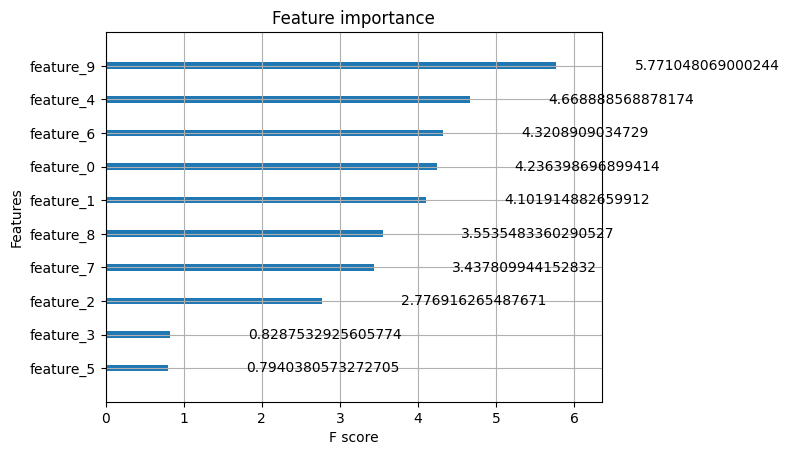

In [91]:
xgb.plot_importance(model, importance_type='gain')

In [94]:
# make a number of sets and get thier union
a = set([1, 2, 3])
b = set([3, 4, 5])
c = set([5, 6, 7])
d = set([7, 8])

a.union(b, c, d)

{1, 2, 3, 4, 5, 6, 7, 8}

In [104]:
set(np.quantile([0, 0, 1, 0, 0, 1, 1], q=np.linspace(0, 1, 3)).tolist())

{0.0, 1.0}

In [1]:
a = set()

In [2]:
len(a)

0